In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from pathlib import Path
from torch import nn
from torchinfo import summary
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

In [2]:
from data_transformation import image_transform
import helper_functions
import mlflow

In [3]:
train_data = ImageFolder("chest_xray/train", transform = image_transform)
test_data = ImageFolder("chest_xray/test", transform = image_transform)
validation_data = ImageFolder("chest_xray/val", transform = image_transform)
image, label = train_data[0]
print(image.shape, label)
print(image)

torch.Size([1, 224, 224]) 0
tensor([[[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3647, 0.3686, 0.3647],
         ...,
         [0.1176, 0.1137, 0.1098,  ..., 0.2353, 0.2353, 0.2353],
         [0.1373, 0.1373, 0.1333,  ..., 0.3176, 0.3216, 0.3216],
         [0.1765, 0.1765, 0.1765,  ..., 0.4196, 0.4235, 0.4235]]])


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)
train_dataloader

In [75]:
class CNN_4Layer_Model(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.layer_stack1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=2,
                  kernel_size=3, stride=1, padding=1),
        nn.ReLU(), ##8, 224, 224
        nn.MaxPool2d(kernel_size=2, stride=2), ##2, 112, 112
        nn.MaxPool2d(kernel_size=2, stride=2), ##2, 56, 56
        nn.MaxPool2d(kernel_size=2, stride=2), ##2, 28, 28
        nn.MaxPool2d(kernel_size=2, stride=2) ##2, 14, 14
    )
    # self.layer_stack2 = nn.Sequential(
    #     nn.Conv2d(in_channels=32, out_channels=32,
    #               kernel_size=3, stride=1, padding=1),
    #     nn.ReLU(),  #224, 224
    #     nn.MaxPool2d(kernel_size=2, stride=2) #112, 112
    # )
    # self.layer_stack3 = nn.Sequential(
    #     nn.Conv2d(in_channels=32, out_channels=32,
    #               kernel_size=3, stride=1, padding=1),
    #     nn.ReLU()  #112, 112
    # )
    # self.layer_stack4 = nn.Sequential(
    #     nn.Conv2d(in_channels=32, out_channels=32,
    #               kernel_size=3, stride=1, padding=1),
    #     nn.ReLU(), #112, 112
    #     nn.MaxPool2d(kernel_size=2, stride=2) #56, 56
    # )
    self.final_stack = nn.Sequential(
        nn.Flatten(), #32, 56,56
        nn.Linear(in_featudense=14*14*2, out_features = output_shape) #
    )
  def forward(self,x):
    x = self.layer_stack1(x)
    # x = self.layer_stack2(x)
    # x = self.layer_stack3(x)
    # x = self.layer_stack4(x)
    x = self.final_stack(x)
    return x

model_CNN_4layer = CNN_4Layer_Model(1, 2)
model_CNN_4layer

CNN_4Layer_Model(
  (layer_stack1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=2, bias=True)
  )
)

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model_CNN_4layer.parameters(),
                      lr = 0.1)

In [68]:
summary(model=model_CNN_4layer,
        input_size=(32, 1, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
CNN_4Layer_Model (CNN_4Layer_Model)      [32, 1, 224, 224]    [32, 2]
├─Sequential (layer_stack1)              [32, 1, 224, 224]    [32, 2, 14, 14]
│    └─Conv2d (0)                        [32, 1, 224, 224]    [32, 2, 224, 224]
│    └─ReLU (1)                          [32, 2, 224, 224]    [32, 2, 224, 224]
│    └─MaxPool2d (2)                     [32, 2, 224, 224]    [32, 2, 112, 112]
│    └─MaxPool2d (3)                     [32, 2, 112, 112]    [32, 2, 56, 56]
│    └─MaxPool2d (4)                     [32, 2, 56, 56]      [32, 2, 28, 28]
│    └─MaxPool2d (5)                     [32, 2, 28, 28]      [32, 2, 14, 14]
├─Sequential (final_stack)               [32, 2, 14, 14]      [32, 2]
│    └─Flatten (0)                       [32, 2, 14, 14]      [32, 392]
│    └─Linear (1)                        [32, 392]            [32, 2]
Total params: 806
Trainable params: 806
Non-trainable params: 0
Total mult-adds (M): 32.14


In [36]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss=0
    train_acc=0
    model_CNN_4layer.to(device)
    for batch, (X, y) in enumerate(train_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = model_CNN_4layer(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.41531 | Train accuracy: 81.75%
Epoch: 1
---------
Train loss: 0.21248 | Train accuracy: 91.68%
Epoch: 2
---------
Train loss: 0.12693 | Train accuracy: 95.30%
Epoch: 3
---------
Train loss: 0.10776 | Train accuracy: 95.92%
Epoch: 4
---------
Train loss: 0.09387 | Train accuracy: 96.45%
Epoch: 5
---------
Train loss: 0.09178 | Train accuracy: 96.47%
Epoch: 6
---------
Train loss: 0.08344 | Train accuracy: 96.76%
Epoch: 7
---------
Train loss: 0.08025 | Train accuracy: 96.89%
Epoch: 8
---------
Train loss: 0.08077 | Train accuracy: 96.89%
Epoch: 9
---------
Train loss: 0.07411 | Train accuracy: 96.91%


In [ ]:
from mlflow.models import infer_signature

In [57]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Pytorch xray new track")

train_time_start_model = timer()

# Train and test model
epochs = 5
for epoch in tqdm(range(epochs)):
    mlflow.set_experiment("xray track train")
    with mlflow.start_run(run_name=f"{epoch+1} Run - train"):
    # for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}\n---------")
        train_loss=0
        train_acc=0
        model_CNN_4layer.to(device)
        for batch, (X, y) in enumerate(train_dataloader):
            X,y = X.to(device), y.to(device)
            y_pred = model_CNN_4layer(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(y_true=y,
                                    y_pred=y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        # Log the loss metric
        mlflow.log_metric("train loss", train_loss)
        mlflow.log_metric("train accuracy", train_acc)
        mlflow.log_metric("epoch", epoch+1)
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", f"4 Layer CNN -epoch {epoch+1}")
        mlflow.log_param('epoch', epoch+1)
        mlflow.end_run()
    mlflow.set_experiment("xray track validation")
    with mlflow.start_run(run_name=f"{epoch+1} Run - validation"):
        val_loss=0
        val_acc=0
        model_CNN_4layer.to(device)
        model_CNN_4layer.eval()
        with torch.inference_mode():
            for X,y in validation_dataloader:
                X,y = X.to(device), y.to(device)

                val_pred = model_CNN_4layer(X)

                val_loss += loss_fn(val_pred, y)
                val_acc += accuracy_fn(y_true = y, y_pred = val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader)
            val_acc /= len(validation_dataloader)
            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")
            # mlflow.log_param('validation loss', val_loss)
            # mlflow.log_param('validation accuracy', val_acc)
        # Log the loss metric
        mlflow.log_metric("validation loss", train_loss)
        mlflow.log_metric("validation accuracy", train_acc)
        mlflow.log_metric("epoch", epoch+1)
        mlflow.log_param('epoch', epoch+1)
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Validation Info", f"4 Layer CNN -epoch {epoch+1}")
        mlflow.end_run()
    mlflow.set_experiment("xray track test")
    with mlflow.start_run(run_name=f"{epoch+1} Run - test"):
        test_loss=0
        test_acc=0
        model_CNN_4layer.to(device)
        model_CNN_4layer.eval()
        with torch.inference_mode():
            for X,y in test_dataloader:
                X,y = X.to(device), y.to(device)

                test_pred = model_CNN_4layer(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        mlflow.log_metric('test loss', test_loss)
        mlflow.log_metric('test accuracy', test_acc)
        mlflow.log_metric("epoch", epoch+1)
        mlflow.log_param('epoch', epoch+1)
        mlflow.end_run()
    # Infer the model signature
    # signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
model_info = mlflow.pytorch.log_model(model_CNN_4layer, 'CNN 4 Layer')

mlflow.end_run()

  0%|          | 0/5 [00:00<?, ?it/s]

2024/02/19 13:13:18 INFO mlflow.tracking.fluent: Experiment with name 'xray track train' does not exist. Creating a new experiment.


Epoch: 1
---------


2024/02/19 13:15:01 INFO mlflow.tracking.fluent: Experiment with name 'xray track validation' does not exist. Creating a new experiment.


Train loss: 0.04176 | Train accuracy: 98.62%


2024/02/19 13:15:01 INFO mlflow.tracking.fluent: Experiment with name 'xray track test' does not exist. Creating a new experiment.


Validation loss: 0.35106 | Validation accuracy: 68.75%

Test loss: 1.45254 | Test accuracy: 71.88%

Epoch: 2
---------
Train loss: 0.04310 | Train accuracy: 98.35%
Validation loss: 0.12266 | Validation accuracy: 100.00%

Test loss: 1.09679 | Test accuracy: 76.41%

Epoch: 3
---------
Train loss: 0.04118 | Train accuracy: 98.49%
Validation loss: 0.05101 | Validation accuracy: 100.00%

Test loss: 0.73467 | Test accuracy: 81.41%

Epoch: 4
---------
Train loss: 0.04053 | Train accuracy: 98.56%
Validation loss: 0.17264 | Validation accuracy: 93.75%

Test loss: 1.13619 | Test accuracy: 75.94%

Epoch: 5
---------
Train loss: 0.03856 | Train accuracy: 98.56%
Validation loss: 0.04742 | Validation accuracy: 100.00%

Test loss: 0.86672 | Test accuracy: 78.59%



In [60]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
# mlflow.set_experiment("Pytorch xray new track")

train_time_start_model = timer()

# Train and test model
epochs = 3
mlflow.set_experiment("xray")
with mlflow.start_run(run_name="train"):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}\n---------")
        train_loss=0
        train_acc=0
        model_CNN_4layer.to(device)
        for batch, (X, y) in enumerate(test_dataloader):
            X,y = X.to(device), y.to(device)
            y_pred = model_CNN_4layer(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(y_true=y,
                                    y_pred=y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(test_dataloader)
        train_acc /= len(test_dataloader)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        # Log the loss metric
        mlflow.log_metric("train loss", train_loss)
        mlflow.log_metric("train accuracy", train_acc)
        mlflow.log_metric("epoch", epoch+1)
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", f"4 Layer CNN -epoch {epoch+1}")
        mlflow.log_param('epoch', epoch+1)
    mlflow.end_run()
with mlflow.start_run(run_name="validation"):
    for epoch in tqdm(range(epochs)):
        val_loss=0
        val_acc=0
        model_CNN_4layer.to(device)
        model_CNN_4layer.eval()
        with torch.inference_mode():
            for X,y in validation_dataloader:
                X,y = X.to(device), y.to(device)

                val_pred = model_CNN_4layer(X)

                val_loss += loss_fn(val_pred, y)
                val_acc += accuracy_fn(y_true = y, y_pred = val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader)
            val_acc /= len(validation_dataloader)
            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")
            # mlflow.log_param('validation loss', val_loss)
            # mlflow.log_param('validation accuracy', val_acc)
        # Log the loss metric
        mlflow.log_metric("validation loss", train_loss)
        mlflow.log_metric("validation accuracy", train_acc)
        mlflow.log_metric("epoch", epoch+1)
        mlflow.log_param('epoch', epoch+1)
        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Validation Info", f"4 Layer CNN -epoch {epoch+1}")
    mlflow.end_run()
with mlflow.start_run(run_name=f"{epoch+1} Run - test"):
    for epoch in tqdm(range(epochs)):
        test_loss=0
        test_acc=0
        model_CNN_4layer.to(device)
        model_CNN_4layer.eval()
        with torch.inference_mode():
            for X,y in validation_dataloader:
                X,y = X.to(device), y.to(device)

                test_pred = model_CNN_4layer(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        mlflow.log_metric('test loss', test_loss)
        mlflow.log_metric('test accuracy', test_acc)
        mlflow.log_metric("epoch", epoch+1)
        mlflow.log_param('epoch', epoch+1)
    mlflow.end_run()
    # Infer the model signature
    # signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
model_info = mlflow.pytorch.log_model(model_CNN_4layer, 'CNN 4 Layer')

mlflow.end_run()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 0.24489 | Train accuracy: 91.41%
Epoch: 2
---------
Train loss: 0.22254 | Train accuracy: 92.19%


MlflowException: INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key='epoch' was already logged with value='1' for run ID='fa486ca1b78548d1afcddfa42d97a1dc'. Attempted logging new value '2'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an MlflowException for overwriting a
logged parameter.

Correct Example:
---------------------------------------
with mlflow.start_run():
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 3)
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 5)
---------------------------------------

Which will create a new nested run for each individual
model and prevent parameter key collisions within the
tracking store.

In [69]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  train_loss=0
  train_acc=0
  model.to(device)
  for batch, (X, y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
  # mlflow.log_param('train loss', train_loss)
  # mlflow.log_param('train accuracy', train_acc)

def test_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  test_loss=0
  test_acc=0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    # mlflow.log_param('test loss', test_loss)
    # mlflow.log_param('test accuracy', test_acc)

def validation_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
  val_loss=0
  val_acc=0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      val_pred = model(X)

      val_loss += loss_fn(val_pred, y)
      val_acc += accuracy_fn(y_true = y, y_pred = val_pred.argmax(dim=1))

    val_loss /= len(data_loader)
    val_acc /= len(data_loader)
    print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")
    # mlflow.log_param('validation loss', val_loss)
    # mlflow.log_param('validation accuracy', val_acc)

In [77]:
torch.manual_seed(42)
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

epochs =3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n---------")
    train_loss=0
    train_acc=0
    model_CNN_4layer.to(device)
    # Training loop
    for batch, (X, y) in enumerate(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = model_CNN_4layer(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(test_dataloader)
    train_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    test_loss=0
    test_acc=0
    model_CNN_4layer.to(device)
    model_CNN_4layer.eval()
    # Test loop
    with torch.inference_mode():
        for X,y in validation_dataloader:
            X,y = X.to(device), y.to(device)

            test_pred = model_CNN_4layer(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

        test_loss /= len(validation_dataloader)
        test_acc /= len(validation_dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        val_loss=0
    val_acc=0
    model_CNN_4layer.to(device)
    model_CNN_4layer.eval()
    # Validation loop
    with torch.inference_mode():
        for X,y in validation_dataloader:
            X,y = X.to(device), y.to(device)

            val_pred = model_CNN_4layer(X)

            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(y_true = y, y_pred = val_pred.argmax(dim=1))

        val_loss /= len(validation_dataloader)
        val_acc /= len(validation_dataloader)
        print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 0.67825 | Train accuracy: 59.22%
Test loss: 0.71226 | Test accuracy: 50.00%

Validation loss: 0.71226 | Validation accuracy: 50.00%

Epoch: 2
---------
Train loss: 0.64388 | Train accuracy: 62.97%
Test loss: 0.79238 | Test accuracy: 50.00%

Validation loss: 0.79238 | Validation accuracy: 50.00%

Epoch: 3
---------
Train loss: 0.60812 | Train accuracy: 64.22%
Test loss: 0.69416 | Test accuracy: 50.00%

Validation loss: 0.69416 | Validation accuracy: 50.00%



In [78]:
mlflow.pytorch.autolog()

# Start training loop
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n---------")
    
    # Training loop
    train_loss = 0
    train_acc = 0
    model_CNN_4layer.to(device)

    for batch, (X, y) in enumerate(validation_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model_CNN_4layer(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

2024/02/19 15:36:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 0.00426 | Train accuracy: 0.31%
Epoch: 2
---------
Train loss: 0.00393 | Train accuracy: 0.42%
Epoch: 3
---------
Train loss: 0.00387 | Train accuracy: 0.42%


In [82]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("your_experiment_name")  # Replace with your experiment name

<Experiment: artifact_location='mlflow-artifacts:/977212133652653503', creation_time=1708337257709, experiment_id='977212133652653503', last_update_time=1708337257709, lifecycle_stage='active', name='your_experiment_name', tags={}>

In [95]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("your_experiment_name1")  # Replace with your experiment name
# Start training loop
epochs = 3
for epoch in tqdm(range(epochs)):
    with mlflow.start_run(run_name=f"1st-model-epoch_{epoch+1}"):
        print(f"Epoch: {epoch+1}\n---------")
        
        # Training loop
        train_loss = 0
        train_acc = 0
        model_CNN_4layer.to(device)

        for batch, (X, y) in enumerate(validation_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model_CNN_4layer(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(validation_dataloader)
        train_acc /= len(validation_dataloader)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_param("epoch", epoch + 1)
        # Log metrics and parameters to MLflow
        # with mlflow.start_run(run_name=f"epoch_{epoch+1}"):
        #     mlflow.log_metric("train_loss", train_loss)
        #     mlflow.log_metric("train_accuracy", train_acc)
        #     mlflow.log_param("epoch", epoch + 1)
            
            # Add more parameters and metrics as needed

        # Validation loop
        val_loss = 0
        val_acc = 0
        model_CNN_4layer.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                val_pred = model_CNN_4layer(X)
                val_loss += loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader)
            val_acc /= len(validation_dataloader)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
            mlflow.log_metric("val_loss", val_loss)
            mlflow.log_metric("val_accuracy", val_acc)

# End of training loop

2024/02/19 15:51:13 INFO mlflow.tracking.fluent: Experiment with name 'your_experiment_name1' does not exist. Creating a new experiment.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 0.45769 | Train accuracy: 87.50%
Validation loss: 0.45007 | Validation accuracy: 87.50%

Epoch: 2
---------
Train loss: 0.45007 | Train accuracy: 87.50%
Validation loss: 0.44238 | Validation accuracy: 87.50%

Epoch: 3
---------
Train loss: 0.44238 | Train accuracy: 87.50%
Validation loss: 0.43466 | Validation accuracy: 93.75%



In [96]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 3
for epoch in tqdm(range(epochs)):
    with mlflow.start_run(run_name=f"1st-model-epoch_{epoch+1}"):
        print(f"Epoch: {epoch+1}\n---------")
        
        # Training loop
        train_loss = 0
        train_acc = 0
        model_CNN_4layer.to(device)

        for batch, (X, y) in enumerate(validation_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model_CNN_4layer(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(validation_dataloader)
        train_acc /= len(validation_dataloader)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_param("epoch", epoch + 1)
        # Log metrics and parameters to MLflow
        # with mlflow.start_run(run_name=f"epoch_{epoch+1}"):
        #     mlflow.log_metric("train_loss", train_loss)
        #     mlflow.log_metric("train_accuracy", train_acc)
        #     mlflow.log_param("epoch", epoch + 1)
            
            # Add more parameters and metrics as needed

        # Validation loop
        val_loss = 0
        val_acc = 0
        model_CNN_4layer.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                val_pred = model_CNN_4layer(X)
                val_loss += loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader)
            val_acc /= len(validation_dataloader)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
            mlflow.log_metric("val_loss", val_loss)
            mlflow.log_metric("val_accuracy", val_acc)

# End of training loop

2024/02/19 16:24:08 INFO mlflow.tracking.fluent: Experiment with name 'new' does not exist. Creating a new experiment.


TypeError: float() argument must be a string or a real number, not 'list'

In [109]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 10

with mlflow.start_run(run_name="CNN 4-Layer Model - 2"):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        model_CNN_4layer.to(device)

        for batch, (X, y) in enumerate(validation_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model_CNN_4layer(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(validation_dataloader)
        train_acc /= len(validation_dataloader)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        model_CNN_4layer.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                val_pred = model_CNN_4layer(X)
                val_loss += loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader)
            val_acc /= len(validation_dataloader)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        model_CNN_4layer.eval()

        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model_CNN_4layer(X)
                test_loss += loss_fn(val_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", val_loss, step=epoch)
        mlflow.log_metric("test accuracy", val_acc, step=epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 0.41631 | Train accuracy: 75.00%
Validation loss: 0.39023 | Validation accuracy: 81.25%

test loss: 1.21391 | test accuracy: 88.30%

Epoch: 2
---------
Train loss: 0.39023 | Train accuracy: 81.25%
Validation loss: 0.36956 | Validation accuracy: 81.25%

test loss: 1.15930 | test accuracy: 88.46%

Epoch: 3
---------
Train loss: 0.36956 | Train accuracy: 81.25%
Validation loss: 0.34661 | Validation accuracy: 87.50%

test loss: 1.22882 | test accuracy: 88.14%

Epoch: 4
---------
Train loss: 0.34661 | Train accuracy: 87.50%
Validation loss: 0.32892 | Validation accuracy: 87.50%

test loss: 1.25077 | test accuracy: 88.46%

Epoch: 5
---------
Train loss: 0.32892 | Train accuracy: 87.50%
Validation loss: 0.31415 | Validation accuracy: 87.50%

test loss: 1.23199 | test accuracy: 87.82%

Epoch: 6
---------
Train loss: 0.31415 | Train accuracy: 87.50%
Validation loss: 0.30067 | Validation accuracy: 87.50%

test loss: 1.17559 | test accuracy: 87.34%

Epoch: 7
-------

In [6]:
from torchvision.models import vgg16, VGG16_Weights
vgg16_weights = VGG16_Weights.DEFAULT
vgg16_weights

VGG16_Weights.IMAGENET1K_V1

In [9]:
vgg16_transforms = vgg16_weights.transforms()
vgg16_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
train_data_vgg16 = ImageFolder("chest_xray/train", transform = vgg16_transforms)
test_data_vgg16 = ImageFolder("chest_xray/test", transform = vgg16_transforms)
validation_data_vgg16 = ImageFolder("chest_xray/val", transform = vgg16_transforms)
image, label = train_data_vgg16[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [11]:
train_dataloader_vgg16 = DataLoader(train_data_vgg16, batch_size=32, shuffle=True)
validation_dataloader_vgg16 = DataLoader(validation_data_vgg16, batch_size=32, shuffle=True)
test_dataloader_vgg16 = DataLoader(test_data_vgg16, batch_size=32, shuffle=True)
train_dataloader_vgg16

In [22]:
vgg16_model = vgg16(weights=vgg16_weights)

for param in vgg16_model.features.parameters():
  param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

summary(model=vgg16_model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     [32

In [23]:
vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.SGD(params = vgg16_model.parameters(),
                      lr = 0.1)

In [24]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model"):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()

        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", val_loss, step=epoch)
        mlflow.log_metric("test accuracy", val_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 4.98415 | Train accuracy: 93.31%
Validation loss: 0.00005 | Validation accuracy: 100.00%

test loss: 13.00525 | test accuracy: 81.09%

Epoch: 2
---------
Train loss: 0.82395 | Train accuracy: 97.37%
Validation loss: 37.58030 | Validation accuracy: 50.00%

test loss: 38.77471 | test accuracy: 67.03%

Epoch: 3
---------
Train loss: 0.90599 | Train accuracy: 97.32%
Validation loss: 0.00000 | Validation accuracy: 100.00%

test loss: 10.04634 | test accuracy: 82.97%

Epoch: 4
---------
Train loss: 0.39022 | Train accuracy: 98.39%
Validation loss: 7.02891 | Validation accuracy: 75.00%

test loss: 17.14404 | test accuracy: 77.81%

Epoch: 5
---------
Train loss: 0.22300 | Train accuracy: 98.96%
Validation loss: 1.07599 | Validation accuracy: 93.75%

test loss: 9.20215 | test accuracy: 84.84%



In [3]:
import torchvision.transforms as transforms
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])

In [4]:
train_data = ImageFolder("chest_xray/train", transform = image_transform)
test_data = ImageFolder("chest_xray/test", transform = image_transform)
validation_data = ImageFolder("chest_xray/val", transform = image_transform)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)
train_dataloader

In [6]:
from transformers import AutoImageProcessor, ViTForImageClassification, ViTModel, ViTFeatureExtractor

2024-02-20 15:08:57.424662: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 15:08:57.424795: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 15:08:57.426016: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 15:08:57.544699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 15:08:59.415452: W tensorflow/compiler/

In [7]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels, encoder):
        super(ImageClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, num_labels),
            # nn.ReLU(),
            # nn.Linear(50, num_labels),
            nn.Sigmoid()
        )

    def forward(self, input_values):
        outputs = self.encoder(pixel_values = input_values)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = ViTFeatureExtractor.from_pretrained(model_checkpoint)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'
num_labels = 2
encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
model_Vit = ImageClassifier(num_labels, encoder)
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(params = model_Vit.parameters(),
#                       lr = 0.1)
optimizer = optim.SGD(model_Vit.parameters(), lr=0.0001)  #, betas=(0.9, 0.999), eps=1e-08)

/home/anant/anaconda3/envs/xrayclf/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [12]:
device

device(type='cuda')

In [9]:
for param in model_Vit.encoder.parameters():
  param.requires_grad = False

# model_vit
# model_Vit

summary(model=model_Vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                                Input Shape          Output Shape
ImageClassifier (ImageClassifier)                                      [32, 3, 224, 224]    [32, 2]
├─ViTModel (encoder)                                                   --                   [32, 768]
│    └─ViTEmbeddings (embeddings)                                      [32, 3, 224, 224]    [32, 197, 768]
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [32, 3, 224, 224]    [32, 196, 768]
│    │    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]
│    └─ViTEncoder (encoder)                                            [32, 197, 768]       [32, 197, 768]
│    │    └─ModuleList (layer)                                         --                   --
│    └─LayerNorm (layernorm)                                           [32, 197, 768]       [32, 197, 768]
│    └─ViTPooler (pooler)                                      

In [14]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="ViT model"):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        model_Vit.to(device)

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model_Vit(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        model_Vit.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                val_pred = model_Vit(X)
                val_loss += loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader)
            val_acc /= len(validation_dataloader)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        model_Vit.eval()

        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model_Vit(X)
                test_loss += loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", val_loss, step=epoch)
        mlflow.log_metric("test accuracy", val_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 0.69056 | Train accuracy: 70.38%
Validation loss: 0.69311 | Validation accuracy: 50.00%

test loss: 0.69183 | test accuracy: 61.56%

Epoch: 2
---------
Train loss: 0.68876 | Train accuracy: 73.81%
Validation loss: 0.69314 | Validation accuracy: 50.00%

test loss: 0.69101 | test accuracy: 62.34%

Epoch: 3
---------
Train loss: 0.68698 | Train accuracy: 74.25%
Validation loss: 0.69319 | Validation accuracy: 50.00%

test loss: 0.69009 | test accuracy: 62.66%

Epoch: 4
---------
Train loss: 0.68524 | Train accuracy: 74.29%
Validation loss: 0.69324 | Validation accuracy: 50.00%



In [5]:
from torchvision.models import DenseNet201_Weights, densenet201
densenet_weights = DenseNet201_Weights.DEFAULT
densenet_weights

DenseNet201_Weights.IMAGENET1K_V1

In [6]:
densenet_transform = densenet_weights.transforms()
densenet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [8]:
train_data_densenet = ImageFolder("chest_xray/train", transform = densenet_transform)
test_data_densenet = ImageFolder("chest_xray/test", transform = densenet_transform)
validation_data_densenet = ImageFolder("chest_xray/val", transform = densenet_transform)
image, label = train_data_densenet[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [9]:
train_dataloader_densenet = DataLoader(train_data_densenet, batch_size=32, shuffle=True)
validation_dataloader_densenet = DataLoader(validation_data_densenet, batch_size=32, shuffle=True)
test_dataloader_densenet = DataLoader(test_data_densenet, batch_size=32, shuffle=True)
train_dataloader_densenet

In [14]:
densenet_model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
densenet_model = densenet201(weights=densenet_weights)

for param in densenet_model.parameters():
    param.requires_grad = False

densenet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1920,
              out_features=2,
              bias=True)
)

summary(model=densenet_model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                       Input Shape          Output Shape
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1920, 7, 7]
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]
│    │    └─_DenseLayer (denselayer2)         [32, 64, 56, 56]     [32, 32, 56, 56]
│    │    └─_DenseLayer (denselayer3)         [32, 64, 56, 56]     [32, 32, 56, 56]
│    │    └─_DenseLayer (denselayer4)         [32, 64, 56, 56]     [32, 32, 56, 56

In [16]:
densenet_loss_fn = nn.CrossEntropyLoss()
densenet_optimizer = optim.RMSprop(params = densenet_model.parameters(),
                      lr = 0.1)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [32]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="DENSENET-201 model"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step = epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        densenet_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_densenet):
            X, y = X.to(device), y.to(device)
            y_pred = densenet_model(X)
            loss = densenet_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            densenet_optimizer.zero_grad()
            loss.backward()
            densenet_optimizer.step()

        train_loss /= len(train_dataloader_densenet)
        train_acc /= len(train_dataloader_densenet)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        densenet_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_densenet:
                X, y = X.to(device), y.to(device)
                val_pred = densenet_model(X)
                val_loss += densenet_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_densenet)
            val_acc /= len(validation_dataloader_densenet)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        densenet_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_densenet:
                X, y = X.to(device), y.to(device)
                test_pred = densenet_model(X)
                test_loss += densenet_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_densenet)
            test_acc /= len(test_dataloader_densenet)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 1.62992 | Train accuracy: 96.32%
Validation loss: 17.37754 | Validation accuracy: 68.75%

test loss: 28.88661 | test accuracy: 75.16%

Epoch: 2
---------
Train loss: 1.66765 | Train accuracy: 96.68%
Validation loss: 4.83646 | Validation accuracy: 87.50%

test loss: 18.59523 | test accuracy: 79.84%

Epoch: 3
---------
Train loss: 1.65370 | Train accuracy: 96.88%
Validation loss: 7.38802 | Validation accuracy: 87.50%

test loss: 22.27160 | test accuracy: 78.28%

Epoch: 4
---------
Train loss: 1.86555 | Train accuracy: 96.51%
Validation loss: 15.01756 | Validation accuracy: 68.75%

test loss: 26.02046 | test accuracy: 78.44%

Epoch: 5
---------
Train loss: 1.18271 | Train accuracy: 97.32%
Validation loss: 35.87493 | Validation accuracy: 62.50%

test loss: 40.21560 | test accuracy: 72.97%



In [33]:
from torchvision.models import alexnet, AlexNet_Weights
alexnet_weights = AlexNet_Weights.DEFAULT
alexnet_weights

AlexNet_Weights.IMAGENET1K_V1

In [34]:
alexnet_transform = alexnet_weights.transforms()
alexnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [35]:
train_data_alexnet = ImageFolder("chest_xray/train", transform = alexnet_transform)
test_data_alexnet = ImageFolder("chest_xray/test", transform = alexnet_transform)
validation_data_alexnet = ImageFolder("chest_xray/val", transform = alexnet_transform)
image, label = train_data_alexnet[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [36]:
train_dataloader_alexnet = DataLoader(train_data_alexnet, batch_size=32, shuffle=True)
validation_dataloader_alexnet = DataLoader(validation_data_alexnet, batch_size=32, shuffle=True)
test_dataloader_alexnet = DataLoader(test_data_alexnet, batch_size=32, shuffle=True)
train_dataloader_alexnet

In [37]:
alexnet_model = alexnet(weights=alexnet_weights)
alexnet_model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/anant/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:22<00:00, 11.1MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
for param in alexnet_model.parameters():
    param.requires_grad = False

alexnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=9216,
              out_features=2,
              bias=True)
)

summary(model=alexnet_model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]
│    └─Conv2d (6)                        [32, 192, 13, 13]    [32, 384, 13, 13]
│    └─ReLU (7)                          [32, 384, 13, 13]    [32, 384, 13, 13]
│    └─Conv2d (8)                        [32, 384, 13, 13]    [32, 256, 13, 13]
│    └─ReLU (9)                          [32, 256, 13, 13]  

In [39]:
alexnet_loss_fn = nn.CrossEntropyLoss()
alexnet_optimizer = optim.RMSprop(params = alexnet_model.parameters(),
                      lr = 0.1)

In [41]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="Alexnet model"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        alexnet_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_alexnet):
            X, y = X.to(device), y.to(device)
            y_pred = alexnet_model(X)
            loss = alexnet_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            alexnet_optimizer.zero_grad()
            loss.backward()
            alexnet_optimizer.step()

        train_loss /= len(train_dataloader_alexnet)
        train_acc /= len(train_dataloader_alexnet)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        alexnet_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_alexnet:
                X, y = X.to(device), y.to(device)
                val_pred = alexnet_model(X)
                val_loss += alexnet_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_alexnet)
            val_acc /= len(validation_dataloader_alexnet)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        alexnet_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_alexnet:
                X, y = X.to(device), y.to(device)
                test_pred = alexnet_model(X)
                test_loss += alexnet_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_alexnet)
            test_acc /= len(test_dataloader_alexnet)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 42.21473 | Train accuracy: 94.38%
Validation loss: 94.66971 | Validation accuracy: 68.75%

test loss: 216.97004 | test accuracy: 78.12%

Epoch: 2
---------
Train loss: 14.05112 | Train accuracy: 97.03%
Validation loss: 15.70276 | Validation accuracy: 87.50%

test loss: 197.57455 | test accuracy: 78.12%

Epoch: 3
---------
Train loss: 8.88869 | Train accuracy: 97.76%
Validation loss: 154.14174 | Validation accuracy: 62.50%

test loss: 269.65472 | test accuracy: 75.78%

Epoch: 4
---------
Train loss: 7.25638 | Train accuracy: 98.18%
Validation loss: 0.00000 | Validation accuracy: 100.00%

test loss: 186.48904 | test accuracy: 82.66%

Epoch: 5
---------
Train loss: 5.74062 | Train accuracy: 98.64%
Validation loss: 223.60416 | Validation accuracy: 56.25%

test loss: 323.53800 | test accuracy: 76.88%



In [3]:
from torchvision.models import VGG16_Weights, vgg16
vgg16_weights = VGG16_Weights.DEFAULT
vgg16_weights

VGG16_Weights.IMAGENET1K_V1

In [4]:
vgg16_transform = vgg16_weights.transforms()
vgg16_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
train_data_vgg16 = ImageFolder("chest_xray/train", transform = vgg16_transform)
test_data_vgg16 = ImageFolder("chest_xray/test", transform = vgg16_transform)
validation_data_vgg16 = ImageFolder("chest_xray/val", transform = vgg16_transform)
image, label = train_data_vgg16[0]
print(image.shape, label)
print(image)

torch.Size([3, 224, 224]) 0
tensor([[[-0.3369, -0.3198, -0.2684,  ..., -0.2513, -0.0972,  0.2967],
         [-0.3369, -0.3027, -0.2856,  ..., -0.2171,  0.1254,  0.5707],
         [-0.3541, -0.3027, -0.2856,  ..., -0.0629,  0.3481,  0.8447],
         ...,
         [-1.0562, -0.9705, -0.8507,  ..., -1.9809, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8507,  ..., -2.0323, -2.0665, -2.0323],
         [-1.0390, -0.9534, -0.8335,  ..., -2.0494, -2.0494, -2.0323]],

        [[-0.2150, -0.1975, -0.1450,  ..., -0.1275,  0.0301,  0.4328],
         [-0.2150, -0.1800, -0.1625,  ..., -0.0924,  0.2577,  0.7129],
         [-0.2325, -0.1800, -0.1625,  ...,  0.0651,  0.4853,  0.9930],
         ...,
         [-0.9503, -0.8627, -0.7402,  ..., -1.8957, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7402,  ..., -1.9482, -1.9832, -1.9482],
         [-0.9328, -0.8452, -0.7227,  ..., -1.9657, -1.9657, -1.9482]],

        [[ 0.0082,  0.0256,  0.0779,  ...,  0.0953,  0.2522,  0.6531],
         [ 0.0082

In [6]:
train_dataloader_vgg16 = DataLoader(train_data_vgg16, batch_size=32, shuffle=True)
validation_dataloader_vgg16 = DataLoader(validation_data_vgg16, batch_size=32, shuffle=True)
test_dataloader_vgg16 = DataLoader(test_data_vgg16, batch_size=32, shuffle=True)
train_dataloader_vgg16

In [7]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

summary(model=vgg16_model,
        input_size=(32,3, 224, 224),
        col_names=['input_size','output_size'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                  Input Shape          Output Shape
VGG (VGG)                                [32, 3, 224, 224]    [32, 2]
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]
│    └─ReLU (6)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─Conv2d (7)                        [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─ReLU (8)                          [32, 128, 112, 112]  [32, 128, 112, 112]
│    └─MaxPool2d (9)                     [32

In [58]:
vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)

In [59]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [60]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("new")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()

        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Train loss: 40.64862 | Train accuracy: 95.26%
Validation loss: 116.17004 | Validation accuracy: 81.25%

test loss: 229.44256 | test accuracy: 78.91%

Epoch: 2
---------
Train loss: 11.40013 | Train accuracy: 97.39%
Validation loss: 0.00000 | Validation accuracy: 100.00%

test loss: 135.59997 | test accuracy: 86.09%

Epoch: 3
---------
Train loss: 6.24675 | Train accuracy: 98.43%
Validation loss: 53.82602 | Validation accuracy: 93.75%

test loss: 290.01850 | test accuracy: 77.81%

Epoch: 4
---------
Train loss: 5.15497 | Train accuracy: 98.73%
Validation loss: 113.32375 | Validation accuracy: 87.50%

test loss: 233.20702 | test accuracy: 83.12%

Epoch: 5
---------
Train loss: 3.22578 | Train accuracy: 98.89%
Validation loss: 38.03481 | Validation accuracy: 93.75%

test loss: 279.21224 | test accuracy: 82.19%



Different Parameters settings

In [9]:
device = 'cuda'

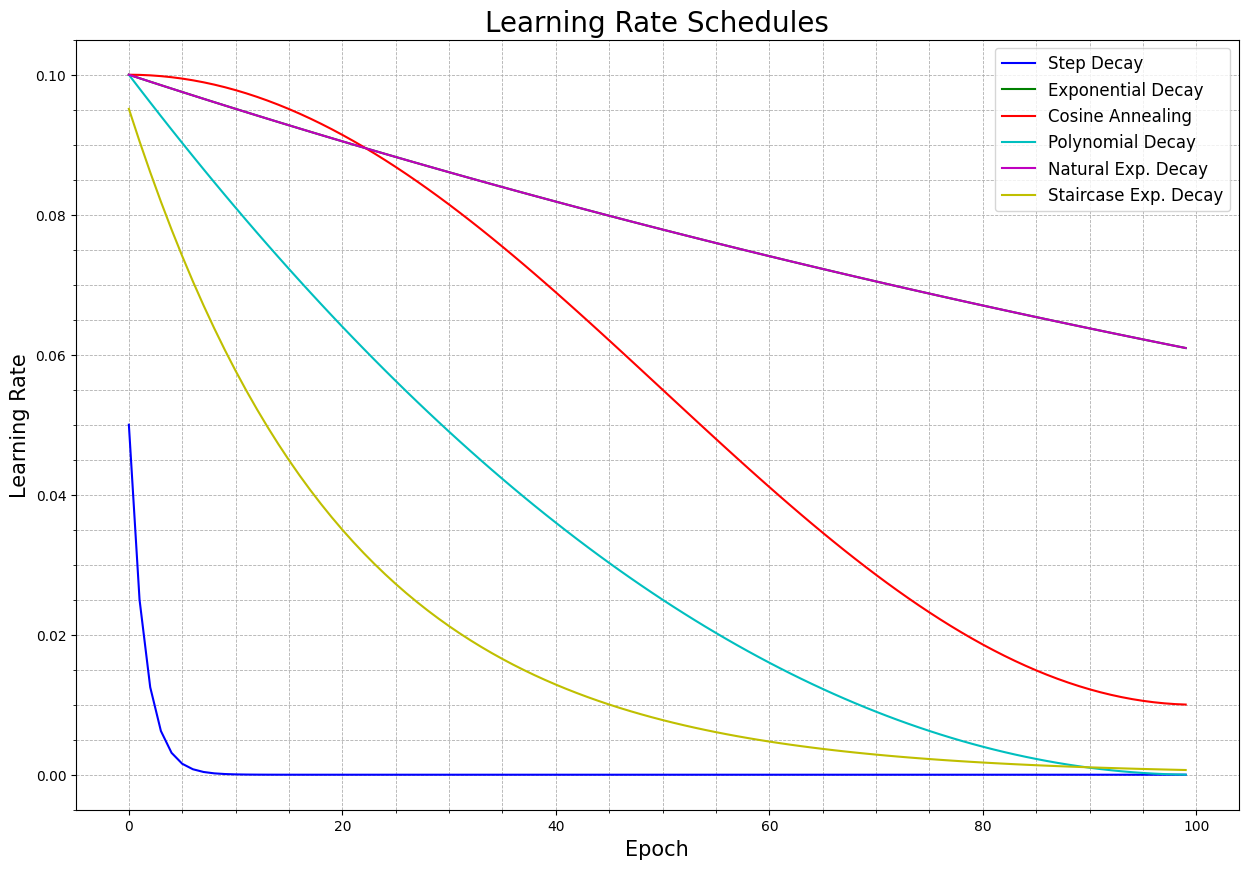

In [42]:
import numpy as np
import matplotlib.pyplot as plt


def polynomial_decay_schedule(initial_lr: float, power: float, max_epochs: int = 100) -> np.ndarray:
    """
    Generate a polynomial decay learning rate schedule.

    Args:
        initial_lr: The initial learning rate.
        power: The power of the polynomial.
        max_epochs: The maximum number of epochs.

    Returns:
        An array of learning rates for each epoch.
    """
    epochs = np.arange(max_epochs)
    lr = initial_lr * ((1 - (epochs / max_epochs)) ** power)
    return lr


def natural_exp_decay_schedule(initial_lr: float, decay_rate: float, max_epochs: int = 100) -> np.ndarray:
    """
    Generate a natural exponential decay learning rate schedule.

    Args:
        initial_lr: The initial learning rate.
        decay_rate: The decay rate.
        max_epochs: The maximum number of epochs.

    Returns:
        An array of learning rates for each epoch.
    """
    epochs = np.arange(max_epochs)
    lr = initial_lr * np.exp(-decay_rate * epochs)
    return lr


def staircase_exp_decay_schedule(initial_lr: float, decay_rate: float, step_size: int, max_epochs: int = 100) -> np.ndarray:
    """
    Generate a staircase exponential decay learning rate schedule.

    Args:
        initial_lr: The initial learning rate.
        decay_rate: The decay rate.
        step_size: The step size.
        max_epochs: The maximum number of epochs.

    Returns:
        An array of learning rates for each epoch.
    """
    epochs = np.arange(max_epochs)
    lr = initial_lr * np.exp(-decay_rate * np.floor((1 + epochs) / step_size))
    return lr


def step_decay_schedule(initial_lr: float, decay_factor: float, step_size: int, max_epochs: int = 100) -> np.ndarray:
    """
    Generate a step decay learning rate schedule.

    Args:
        initial_lr: The initial learning rate.
        decay_factor: The decay factor.
        step_size: The step size.
        max_epochs: The maximum number of epochs.

    Returns:
        An array of learning rates for each epoch.
    """
    epochs = np.arange(max_epochs)
    lr = initial_lr * (decay_factor ** (1 + epochs) / step_size)
    return lr


def cosine_annealing_schedule(lr_min: float, lr_max: float, max_epochs: int = 100) -> np.ndarray:
    """
    Generate a cosine annealing learning rate schedule.

    Args:
        lr_min: The minimum learning rate.
        lr_max: The maximum learning rate.
        max_epochs: The maximum number of epochs.

    Returns:
        An array of learning rates for each epoch.
    """
    epochs = np.arange(max_epochs)
    lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epochs / max_epochs * np.pi))
    return lr


def exponential_decay_schedule(initial_lr: float, decay_rate: float, max_epochs: int = 100) -> np.ndarray:
    """
    Generate an exponential decay learning rate schedule.

    Args:
        initial_lr: The initial learning rate.
        decay_rate: The decay rate.
        max_epochs: The maximum number of epochs.

    Returns:
        An array of learning rates for each epoch.
    """
    epochs = np.arange(max_epochs)
    lr = initial_lr * np.exp(-decay_rate * epochs)
    return lr


# Define the learning rate schedules
schedules = {
    "Step Decay": step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=1),
    "Exponential Decay": exponential_decay_schedule(initial_lr=0.1, decay_rate=0.005),
    "Cosine Annealing": cosine_annealing_schedule(lr_min=0.01, lr_max=0.1),
    "Polynomial Decay": polynomial_decay_schedule(initial_lr=0.1, power=2),
    "Natural Exp. Decay": natural_exp_decay_schedule(initial_lr=0.1, decay_rate=0.005),
    "Staircase Exp. Decay": staircase_exp_decay_schedule(initial_lr=0.1, decay_rate=0.05, step_size=1),
}

# Define a color palette
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot with defined colors
plt.figure(figsize=(15, 10))
for color, (schedule_name, schedule) in zip(colors, schedules.items()):
    plt.plot(schedule, label=schedule_name, color=color)

plt.title('Learning Rate Schedules', fontsize=20)
plt.ylabel('Learning Rate', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.minorticks_on()
plt.legend(prop={'size': 12})
plt.show()

In [44]:
step_decay_schedule = lambda x: x/10


array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [51]:
vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)
def polynomial_decay_schedule(x):
    return 0.1 * ((1 - (x / 10)) ** 2)
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, polynomial_decay_schedule)

In [57]:
vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)
def polynomial_decay_schedule(x):
    return 0.1 * ((1 - (x / 10)) ** 2)
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, polynomial_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model - polynomial decay rate"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0100 -> 0.0081
Train loss: 1.78014 | Train accuracy: 98.35%
Validation loss: 9.51118 | Validation accuracy: 87.50%

test loss: 30.55638 | test accuracy: 80.00%

Epoch: 2
---------
Epoch 1: SGD lr 0.0081 -> 0.0064
Train loss: 0.05850 | Train accuracy: 99.64%
Validation loss: 0.00000 | Validation accuracy: 100.00%

test loss: 25.21283 | test accuracy: 82.81%

Epoch: 3
---------
Epoch 2: SGD lr 0.0064 -> 0.0049
Train loss: 0.10419 | Train accuracy: 99.62%
Validation loss: 8.20458 | Validation accuracy: 81.25%

test loss: 24.14189 | test accuracy: 81.41%

Epoch: 4
---------
Epoch 3: SGD lr 0.0049 -> 0.0036
Train loss: 0.02625 | Train accuracy: 99.81%
Validation loss: 11.94108 | Validation accuracy: 81.25%

test loss: 39.41653 | test accuracy: 77.97%

Epoch: 5
---------
Epoch 4: SGD lr 0.0036 -> 0.0025
Train loss: 0.03271 | Train accuracy: 99.87%
Validation loss: 2.18991 | Validation accuracy: 93.75%

test loss: 26.47239 | test accuracy: 82.03%



In [54]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)
def natural_exponential_decay_schedule(epochs):
    return 0.1 * np.exp(-0.005 * epochs)
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer,natural_exponential_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model - natural exp decay rate"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0100 -> 0.0100
Train loss: 4.46523 | Train accuracy: 94.80%
Validation loss: 11.92954 | Validation accuracy: 81.25%

test loss: 28.99170 | test accuracy: 74.38%

Epoch: 2
---------
Epoch 1: SGD lr 0.0100 -> 0.0099
Train loss: 1.21819 | Train accuracy: 97.49%
Validation loss: 33.95824 | Validation accuracy: 68.75%

test loss: 48.27446 | test accuracy: 69.84%

Epoch: 3
---------
Epoch 2: SGD lr 0.0099 -> 0.0099
Train loss: 0.50625 | Train accuracy: 98.68%
Validation loss: 0.00000 | Validation accuracy: 100.00%

test loss: 16.62971 | test accuracy: 81.25%

Epoch: 4
---------
Epoch 3: SGD lr 0.0099 -> 0.0098
Train loss: 0.49608 | Train accuracy: 98.54%
Validation loss: 7.48392 | Validation accuracy: 87.50%

test loss: 18.51695 | test accuracy: 82.66%

Epoch: 5
---------
Epoch 4: SGD lr 0.0098 -> 0.0098
Train loss: 0.36739 | Train accuracy: 99.00%
Validation loss: 26.50035 | Validation accuracy: 68.75%

test loss: 38.94831 | test accuracy: 75.47%



In [55]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)
def staircase_decay_schedule(epochs):
    return 0.1 * np.exp(-0.05 * np.floor((1 + epochs) / 1))
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, staircase_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model - staircase decay rate"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0095 -> 0.0090
Train loss: 4.05468 | Train accuracy: 94.88%
Validation loss: 3.83007 | Validation accuracy: 87.50%

test loss: 16.20084 | test accuracy: 80.62%

Epoch: 2
---------
Epoch 1: SGD lr 0.0090 -> 0.0086
Train loss: 0.96223 | Train accuracy: 97.64%
Validation loss: 3.79757 | Validation accuracy: 87.50%

test loss: 22.16279 | test accuracy: 78.91%

Epoch: 3
---------
Epoch 2: SGD lr 0.0086 -> 0.0082
Train loss: 0.45681 | Train accuracy: 98.39%
Validation loss: 1.28257 | Validation accuracy: 93.75%

test loss: 6.48202 | test accuracy: 90.62%

Epoch: 4
---------
Epoch 3: SGD lr 0.0082 -> 0.0078
Train loss: 0.34385 | Train accuracy: 98.87%
Validation loss: 9.50989 | Validation accuracy: 75.00%

test loss: 28.24787 | test accuracy: 78.12%

Epoch: 5
---------
Epoch 4: SGD lr 0.0078 -> 0.0074
Train loss: 0.18089 | Train accuracy: 99.25%
Validation loss: 4.56745 | Validation accuracy: 87.50%

test loss: 18.59859 | test accuracy: 82.03%



In [56]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)
def cosine_decay_schedule(epochs):
    return 0.01 + 0.5 * (0.1 - 0.01) * (1 + np.cos(epochs / 10 * np.pi))
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, cosine_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model - Cosine decay rate"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0100 -> 0.0098
Train loss: 3.89720 | Train accuracy: 95.11%
Validation loss: 27.00271 | Validation accuracy: 56.25%

test loss: 44.09079 | test accuracy: 71.09%

Epoch: 2
---------
Epoch 1: SGD lr 0.0098 -> 0.0091
Train loss: 0.88772 | Train accuracy: 97.70%
Validation loss: 9.34023 | Validation accuracy: 81.25%

test loss: 24.96466 | test accuracy: 79.53%

Epoch: 3
---------
Epoch 2: SGD lr 0.0091 -> 0.0081
Train loss: 0.61629 | Train accuracy: 98.64%
Validation loss: 2.57691 | Validation accuracy: 93.75%

test loss: 25.48791 | test accuracy: 78.44%

Epoch: 4
---------
Epoch 3: SGD lr 0.0081 -> 0.0069
Train loss: 0.24883 | Train accuracy: 98.98%
Validation loss: 9.79314 | Validation accuracy: 81.25%

test loss: 26.54119 | test accuracy: 79.22%

Epoch: 5
---------
Epoch 4: SGD lr 0.0069 -> 0.0055
Train loss: 0.16944 | Train accuracy: 99.48%
Validation loss: 5.88496 | Validation accuracy: 81.25%

test loss: 19.14427 | test accuracy: 82.50%



In [ ]:
optimizers = [optim.SGD(params=vgg16_model.parameters(), lr=0.01), optim.RMSprop(params=vgg16_model.parameters(), lr=0.01), optim.Adam(params=vgg16_model.parameters(), lr=0.01)]
lrs = [cosine_decay_schedule, polynomial_decay_schedule, exponential_decay_schedule]
lrs_string = ["cosine_decay_schedule", "polynomial_decay_schedule", "exponential_decay_schedule"]
for optimizer in optimizers:
    for num, lr in enumerate(lrs):
        vgg16_model = vgg16(weights=vgg16_weights)
        vgg16_model
        for param in vgg16_model.parameters():
            param.requires_grad = False

        vgg16_model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=25088,
                    out_features=2,
                    bias=True)
        )

        vgg16_loss_fn = nn.CrossEntropyLoss()
        vgg16_optimizer = optimizer
        scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, lr)

        mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
        mlflow.set_experiment("VGG - more")  # Replace with your experiment name
        # Start training loop
        epochs = 5

        with mlflow.start_run(run_name=f"VGG16 model - {lrs_string[num]}"):
            for epoch in tqdm(range(epochs)):
                mlflow.log_metric("epoch", epoch, step=epoch)
                mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
                print(f"Epoch: {epoch+1}\n---------")

                #Training Loop
                train_loss = 0
                train_acc = 0
                vgg16_model.to(device)

                for batch, (X, y) in enumerate(train_dataloader_vgg16):
                    X, y = X.to(device), y.to(device)
                    y_pred = vgg16_model(X)
                    loss = vgg16_loss_fn(y_pred, y)
                    train_loss += loss.item()
                    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
                    vgg16_optimizer.zero_grad()
                    loss.backward()
                    vgg16_optimizer.step()
                
                before_lr = vgg16_optimizer.param_groups[0]["lr"]
                scheduler.step()
                after_lr = vgg16_optimizer.param_groups[0]["lr"]
                print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
                train_loss /= len(train_dataloader_vgg16)
                train_acc /= len(train_dataloader_vgg16)
                
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("train_accuracy", train_acc, step=epoch)
                # mlflow.log_param("epoch", epoch + 1)

                val_loss = 0
                val_acc = 0
                vgg16_model.eval()

                with torch.inference_mode():
                    for X, y in validation_dataloader_vgg16:
                        X, y = X.to(device), y.to(device)
                        val_pred = vgg16_model(X)
                        val_loss += vgg16_loss_fn(val_pred, y).item()
                        val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

                    val_loss /= len(validation_dataloader_vgg16)
                    val_acc /= len(validation_dataloader_vgg16)

                    print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

                    # Log validation metrics to MLflow
                mlflow.log_metric("val_loss", val_loss, step=epoch)
                mlflow.log_metric("val_accuracy", val_acc, step=epoch)

                test_loss = 0
                test_acc = 0
                vgg16_model.eval()

                with torch.inference_mode():
                    for X, y in test_dataloader_vgg16:
                        X, y = X.to(device), y.to(device)
                        test_pred = vgg16_model(X)
                        test_loss += vgg16_loss_fn(test_pred, y).item()
                        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

                    test_loss /= len(test_dataloader_vgg16)
                    test_acc /= len(test_dataloader_vgg16)

                    print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

                    # Log validation metrics to MLflow
                mlflow.log_metric("test_loss", test_loss, step=epoch)
                mlflow.log_metric("test accuracy", test_acc, step=epoch)

In [62]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.Adam(params = vgg16_model.parameters(),
                      lr = 0.1)

scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, cosine_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model-Cosine-Adam"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0100 -> 0.0098
Train loss: 1.21617 | Train accuracy: 95.19%
Validation loss: 8.48681 | Validation accuracy: 75.00%

test loss: 12.10640 | test accuracy: 78.59%

Epoch: 2
---------
Epoch 1: SGD lr 0.0098 -> 0.0091
Train loss: 0.34467 | Train accuracy: 98.31%
Validation loss: 15.07901 | Validation accuracy: 75.00%

test loss: 15.77994 | test accuracy: 74.69%

Epoch: 3
---------
Epoch 2: SGD lr 0.0091 -> 0.0081
Train loss: 0.36524 | Train accuracy: 98.50%
Validation loss: 12.65777 | Validation accuracy: 75.00%

test loss: 20.40805 | test accuracy: 73.91%

Epoch: 4
---------
Epoch 3: SGD lr 0.0081 -> 0.0069
Train loss: 0.16799 | Train accuracy: 99.10%
Validation loss: 0.96347 | Validation accuracy: 93.75%

test loss: 6.85001 | test accuracy: 88.12%

Epoch: 5
---------
Epoch 4: SGD lr 0.0069 -> 0.0055
Train loss: 0.13696 | Train accuracy: 99.25%
Validation loss: 9.93060 | Validation accuracy: 81.25%

test loss: 17.94775 | test accuracy: 77.66%



In [63]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.Adam(params = vgg16_model.parameters(),
                      lr = 0.01)
def cosine_decay_schedule(epochs):
    return 0.001 + 0.5 * (0.01 - 0.001) * (1 + np.cos(epochs / 10 * np.pi))
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, cosine_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model-Cosine-Adam-0.01"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0001 -> 0.0001
Train loss: 0.13488 | Train accuracy: 94.79%
Validation loss: 0.16278 | Validation accuracy: 100.00%

test loss: 0.54598 | test accuracy: 79.38%

Epoch: 2
---------
Epoch 1: SGD lr 0.0001 -> 0.0001
Train loss: 0.05816 | Train accuracy: 98.10%
Validation loss: 0.36379 | Validation accuracy: 75.00%

test loss: 0.84093 | test accuracy: 74.84%

Epoch: 3
---------
Epoch 2: SGD lr 0.0001 -> 0.0001
Train loss: 0.04239 | Train accuracy: 98.72%
Validation loss: 0.20409 | Validation accuracy: 93.75%

test loss: 0.74303 | test accuracy: 79.06%

Epoch: 4
---------
Epoch 3: SGD lr 0.0001 -> 0.0001
Train loss: 0.03289 | Train accuracy: 99.16%
Validation loss: 0.28821 | Validation accuracy: 81.25%

test loss: 0.82374 | test accuracy: 77.34%

Epoch: 5
---------
Epoch 4: SGD lr 0.0001 -> 0.0001
Train loss: 0.02584 | Train accuracy: 99.42%
Validation loss: 0.21987 | Validation accuracy: 81.25%

test loss: 0.77185 | test accuracy: 79.38%



In [64]:
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)

vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.SGD(params = vgg16_model.parameters(),
                      lr = 0.01)
def cosine_decay_schedule(epochs):
    return 0.001 + 0.5 * (0.01 - 0.001) * (1 + np.cos(epochs / 10 * np.pi))
scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, cosine_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG - Final")  # Replace with your experiment name
# Start training loop
epochs = 5

with mlflow.start_run(run_name="VGG16 model-Cosine-SGD-0.01"):
    for epoch in tqdm(range(epochs)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch+1}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 0: SGD lr 0.0001 -> 0.0001
Train loss: 0.30682 | Train accuracy: 89.51%
Validation loss: 0.29444 | Validation accuracy: 87.50%

test loss: 0.52717 | test accuracy: 73.59%

Epoch: 2
---------
Epoch 1: SGD lr 0.0001 -> 0.0001
Train loss: 0.16678 | Train accuracy: 94.80%
Validation loss: 0.22891 | Validation accuracy: 100.00%

test loss: 0.53306 | test accuracy: 74.22%

Epoch: 3
---------
Epoch 2: SGD lr 0.0001 -> 0.0001
Train loss: 0.13861 | Train accuracy: 95.46%
Validation loss: 0.20796 | Validation accuracy: 100.00%

test loss: 0.53646 | test accuracy: 74.53%

Epoch: 4
---------
Epoch 3: SGD lr 0.0001 -> 0.0001
Train loss: 0.12457 | Train accuracy: 95.63%
Validation loss: 0.19756 | Validation accuracy: 100.00%

test loss: 0.54934 | test accuracy: 74.69%

Epoch: 5
---------
Epoch 4: SGD lr 0.0001 -> 0.0001
Train loss: 0.11618 | Train accuracy: 95.97%
Validation loss: 0.20928 | Validation accuracy: 87.50%

test loss: 0.58593 | test accuracy: 73.75%



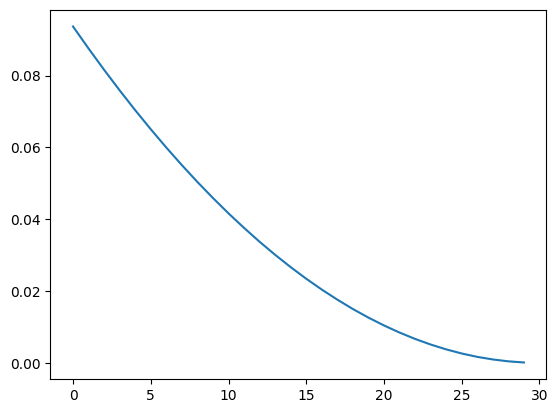

In [19]:
def polynomial_decay_schedule(x):
    return 0.1 * ((1 - (x / 31)) ** 2)
import matplotlib.pyplot as plt
plt.plot([round(polynomial_decay_schedule(x), ndigits=5) for x in range(1,31)])
plt.show()

In [20]:
[round(polynomial_decay_schedule(x), ndigits=5) for x in range(1,31)]

[0.09365,
 0.08751,
 0.08158,
 0.07586,
 0.07034,
 0.06504,
 0.05994,
 0.05505,
 0.05036,
 0.04589,
 0.04162,
 0.03757,
 0.03371,
 0.03007,
 0.02664,
 0.02341,
 0.0204,
 0.01759,
 0.01498,
 0.01259,
 0.01041,
 0.00843,
 0.00666,
 0.0051,
 0.00375,
 0.0026,
 0.00166,
 0.00094,
 0.00042,
 0.0001]

In [22]:
device = 'cuda'
vgg16_model = vgg16(weights=vgg16_weights)
vgg16_model
for param in vgg16_model.parameters():
    param.requires_grad = False

vgg16_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=25088,
              out_features=2,
              bias=True)
)


vgg16_loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = optim.RMSprop(params = vgg16_model.parameters(),
                      lr = 0.1)

scheduler = lr_scheduler.LambdaLR(vgg16_optimizer, polynomial_decay_schedule)

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("VGG-Final-poly-decay-0.01")  # Replace with your experiment name
# Start training loop
epochs = 30

with mlflow.start_run(run_name="VGG16 model - polynomial decay rate"):
    for epoch in tqdm(range(1, epochs+1)):
        mlflow.log_metric("epoch", epoch, step=epoch)
        mlflow.log_metric('lr', vgg16_optimizer.param_groups[0]["lr"], step=epoch)
        print(f"Epoch: {epoch}\n---------")

        #Training Loop
        train_loss = 0
        train_acc = 0
        vgg16_model.to(device)

        for batch, (X, y) in enumerate(train_dataloader_vgg16):
            X, y = X.to(device), y.to(device)
            y_pred = vgg16_model(X)
            loss = vgg16_loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            vgg16_optimizer.zero_grad()
            loss.backward()
            vgg16_optimizer.step()
        
        before_lr = vgg16_optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = vgg16_optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        train_loss /= len(train_dataloader_vgg16)
        train_acc /= len(train_dataloader_vgg16)
        
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        # mlflow.log_param("epoch", epoch + 1)

        val_loss = 0
        val_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in validation_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                val_pred = vgg16_model(X)
                val_loss += vgg16_loss_fn(val_pred, y).item()
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))

            val_loss /= len(validation_dataloader_vgg16)
            val_acc /= len(validation_dataloader_vgg16)

            print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)

        test_loss = 0
        test_acc = 0
        vgg16_model.eval()

        with torch.inference_mode():
            for X, y in test_dataloader_vgg16:
                X, y = X.to(device), y.to(device)
                test_pred = vgg16_model(X)
                test_loss += vgg16_loss_fn(test_pred, y).item()
                test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

            test_loss /= len(test_dataloader_vgg16)
            test_acc /= len(test_dataloader_vgg16)

            print(f"test loss: {test_loss:.5f} | test accuracy: {test_acc:.2f}%\n")

            # Log validation metrics to MLflow
        mlflow.log_metric("test_loss", test_loss, step=epoch)
        mlflow.log_metric("test accuracy", test_acc, step=epoch)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
---------
Epoch 1: SGD lr 0.0100 -> 0.0094
Train loss: 4.28979 | Train accuracy: 94.96%
Validation loss: 6.02139 | Validation accuracy: 87.50%

test loss: 20.85166 | test accuracy: 78.75%

Epoch: 2
---------
Epoch 2: SGD lr 0.0094 -> 0.0088
Train loss: 1.05211 | Train accuracy: 97.62%
Validation loss: 0.00000 | Validation accuracy: 100.00%

test loss: 9.68992 | test accuracy: 88.44%

Epoch: 3
---------
Epoch 3: SGD lr 0.0088 -> 0.0082
Train loss: 0.75658 | Train accuracy: 97.80%
Validation loss: 2.80374 | Validation accuracy: 93.75%

test loss: 21.55750 | test accuracy: 82.03%

Epoch: 4
---------
Epoch 4: SGD lr 0.0082 -> 0.0076
Train loss: 0.28640 | Train accuracy: 98.98%
Validation loss: 13.88985 | Validation accuracy: 75.00%

test loss: 28.15134 | test accuracy: 77.19%

Epoch: 5
---------
Epoch 5: SGD lr 0.0076 -> 0.0070
Train loss: 0.21396 | Train accuracy: 99.29%
Validation loss: 23.79757 | Validation accuracy: 68.75%

test loss: 32.84656 | test accuracy: 77.19%

Epoch: 6

In [23]:
torch.save(vgg16_model, "vgg16_final_model.pt")

In [26]:
traced_model = torch.jit.trace(vgg16_model.to('cpu'), torch.randn(1,3,224,224))
torch.jit.save(traced_model, "vgg16_final_model_jit.pt")